![](images/EscUpmPolit_p.gif "UPM")

# Course Notes for Learning Intelligent Systems

Department of Telematic Engineering Systems, Universidad Politécnica de Madrid, © 2016 Carlos A. Iglesias

## [Introduction to Machine Learning II](3_0_0_Intro_ML_2.ipynb)

# Exercise 2 - The Titanic Dataset

In this exercise we are going to put in practice what we have learnt in the notebooks of the session. 

In the previous notebook we have been applying the SVM machine learning algorithm.

Your task is to apply other machine learning algorithms (at least 2) that you have seen in theory or others you are interested in.

You should compare the algorithms and describe your experiments.

### Cargar y limpiar datos

Se cargan los datos del titanic y se limpian para quitar las variables vacías y los tipos que son objetos.

In [4]:
# General import and load data
import pandas as pd
import numpy as np

from pandas import Series, DataFrame

# Training and test spliting
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing

# Estimators
from sklearn.svm import SVC

# Evaluation
from sklearn import metrics
from sklearn.cross_validation import cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Optimization
from sklearn.grid_search import GridSearchCV

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)


# if matplotlib is not set inline, you will not see plots
#alternatives auto gtk gtk2 inline osx qt qt5 wx tk
#%matplotlib auto
#%matplotlib qt
%matplotlib inline
%run plot_learning_curve

In [6]:
#We get a URL with raw content (not HTML one)
url="https://raw.githubusercontent.com/gsi-upm/sitc/master/ml2/data-titanic/train.csv"
df = pd.read_csv(url)
df.head()


#Fill missing values
df['Age'].fillna(df['Age'].mean(), inplace=True)
df['Sex'].fillna('male', inplace=True)
df['Embarked'].fillna('S', inplace=True)

# Encode categorical variables
df['Age'] = df['Age'].fillna(df['Age'].median())
df.loc[df["Sex"] == "male", "Sex"] = 0
df.loc[df["Sex"] == "female", "Sex"] = 1
df.loc[df["Embarked"] == "S", "Embarked"] = 0
df.loc[df["Embarked"] == "C", "Embarked"] = 1
df.loc[df["Embarked"] == "Q", "Embarked"] = 2

# Drop colums
df.drop(['Cabin', 'Ticket', 'Name'], axis=1, inplace=True)
df['Sex'] = df['Sex'].astype(np.int64)
df['Embarked'] = df['Embarked'].astype(np.int64)
df.dtypes

#Show proprocessed df
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,0,22.0,1,0,7.2500,0
1,2,1,1,1,38.0,1,0,71.2833,1
2,3,1,3,1,26.0,0,0,7.9250,0
3,4,1,1,1,35.0,1,0,53.1000,0
4,5,0,3,0,35.0,0,0,8.0500,0


### Preprocesado: Division en test y train

Los valores de la x con todas las features salvo si ha sobrevivido. La y es si han sobrevivido. Para la división en datos de entrenamiento y test utilizo un random_state de 33.

In [10]:
# Features of the model
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
# Transform dataframe in numpy arrays
X = df[features].values
y = df['Survived'].values



# Test set will be the 25% taken randomly
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33)

# Preprocess: normalize
#scaler = preprocessing.StandardScaler().fit(X_train)
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

# KNeighborsClassifier

### Definir el modelo

Definición del modelo Knn con k=15

In [14]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Create kNN model
model = KNeighborsClassifier(n_neighbors=15)

# Train the model using the training sets
model.fit(x_train, y_train)
#print("Prediction ", model.predict(x_train))
#print("Expected ", y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')

Obtenemos las siguientes exactitudes en training y testing (accuracy) utilizandoo este modelo con k=15.

In [15]:
# Evaluate Accuracy in training

from sklearn import metrics
y_train_pred = model.predict(x_train)
print("Accuracy in training", metrics.accuracy_score(y_train, y_train_pred))

Accuracy in training 0.75


In [16]:
# Now we evaluate error in testing
y_test_pred = model.predict(x_test)
print("Accuracy in testing ", metrics.accuracy_score(y_test, y_test_pred))

Accuracy in testing  0.699551569507


Lógicamente la exactitud en entrenamiento es mayor que la de test porque el modelo se ha ajustado con esos datos.

Ahora calculamos las metricas del modelo basándonos en los datos de test.

In [20]:
print(metrics.classification_report(y_test, y_test_pred))


             precision    recall  f1-score   support

          0       0.72      0.82      0.77       134
          1       0.66      0.52      0.58        89

avg / total       0.69      0.70      0.69       223



Obtenemos la siguiente matriz de confusión:

In [22]:
print(metrics.confusion_matrix(y_test, y_test_pred))

[[110  24]
 [ 43  46]]


Tenemos 110 verdaderos positivos, es decir, 110 personas que no sobreviven y el modelo lo acierta. 46 verdaderos positivos, que acierta el modelo que sobreviven. Tenemos también 43 falsos negativos y 24 falsos positivos.

### ROC (Receiver Operating Characteristic ) and AUC (Area Under the Curve)

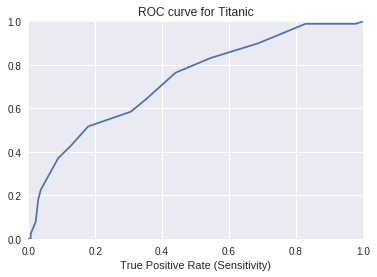

In [25]:
y_pred_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Titanic')
plt.xlabel('False Positive Rate (1 - Recall)')
plt.xlabel('True Positive Rate (Sensitivity)')
plt.grid(True)


In [26]:
#Threshold used by the decision function, thresholds[0] is the number of 
thresholds

array([ 2.        ,  1.        ,  0.93333333,  0.86666667,  0.8       ,
        0.73333333,  0.66666667,  0.6       ,  0.53333333,  0.46666667,
        0.4       ,  0.33333333,  0.26666667,  0.2       ,  0.13333333,
        0.06666667,  0.        ])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fba7fb23710>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fba7fa31cf8>], dtype=object)

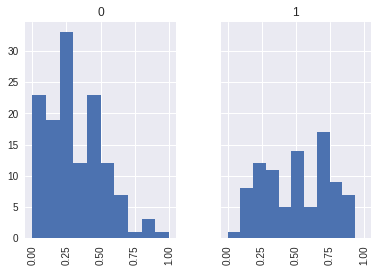

In [28]:
#Histogram of probability vs actual
dprob = pd.DataFrame(data = {'probability':y_pred_prob, 'actual':y_test})
dprob.probability.hist(by=dprob.actual, sharex=True, sharey=True)

In [29]:
#Function to evaluate thresholds of the ROC curve
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Recall:', 1 - fpr[thresholds > threshold][-1])

In [33]:
evaluate_threshold(0.74)
# AUX
print(roc_auc_score(y_test, y_pred_prob))

Sensitivity: 0.179775280899
Recall: 0.970149253731
0.728156967969


### K-fold

Hacemos validación cruzada k-fold con k=10.

In [36]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# create a composite estimator made by a pipeline of preprocessing and the KNN model
model = Pipeline([
        ('scaler', StandardScaler()),
        ('kNN', KNeighborsClassifier())
])

# create a k-fold cross validation iterator of k=10 folds
cv = KFold(10, shuffle=True, random_state=33)

# by default the score used is the one returned by score method of the estimator (accuracy)
scores = cross_val_score(model, X, y, cv=cv)
print(scores)

[ 0.81111111  0.85393258  0.83146067  0.80898876  0.7752809   0.76404494
  0.84269663  0.7752809   0.75280899  0.85393258]


La media de las exactitudes es:

In [37]:
from scipy.stats import sem
def mean_score(scores):
    return ("Mean score: {0:.3f} (+/- {1:.3f})").format(np.mean(scores), sem(scores))
print(mean_score(scores))

Mean score: 0.807 (+/- 0.012)


### Mejora del modelo

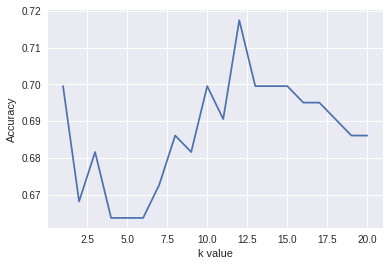

In [38]:
k_range = range(1, 21)
accuracy = []
for k in k_range:
    m = KNeighborsClassifier(k)
    m.fit(x_train, y_train)
    y_test_pred = m.predict(x_test)
    accuracy.append(metrics.accuracy_score(y_test, y_test_pred))
plt.plot(k_range, accuracy)
plt.xlabel('k value')
plt.ylabel('Accuracy')

El mejor valor de K es 12, por tanto, hago la repetición para mejorar el modelo.

In [40]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Create kNN model
model = KNeighborsClassifier(n_neighbors=12)

# Train the model using the training sets
model.fit(x_train, y_train)
from sklearn import metrics
y_train_pred = model.predict(x_train)
print("Accuracy in training", metrics.accuracy_score(y_train, y_train_pred))
# Now we evaluate error in testing
y_test_pred = model.predict(x_test)
print("Accuracy in testing ", metrics.accuracy_score(y_test, y_test_pred))
print(metrics.classification_report(y_test, y_test_pred))
print(metrics.confusion_matrix(y_test, y_test_pred))

Accuracy in training 0.747005988024
Accuracy in testing  0.717488789238
             precision    recall  f1-score   support

          0       0.72      0.87      0.79       134
          1       0.71      0.49      0.58        89

avg / total       0.72      0.72      0.71       223

[[116  18]
 [ 45  44]]


# Aprendizaje basado en árbol de decisión

In [44]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np

from sklearn import tree

max_depth=3
random_state=33

# Create decision tree model
model = tree.DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)

# Train the model using the training sets
model.fit(x_train, y_train)
#print("Prediction ", model.predict(x_train))
#print("Expected ", y_train)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=33, splitter='best')

In [45]:
print("Predicted probabilities", model.predict_proba(x_train[:10]))

Predicted probabilities [[ 0.65517241  0.34482759]
 [ 0.65517241  0.34482759]
 [ 0.89032258  0.10967742]
 [ 0.89032258  0.10967742]
 [ 0.89032258  0.10967742]
 [ 0.89032258  0.10967742]
 [ 0.89032258  0.10967742]
 [ 0.01449275  0.98550725]
 [ 0.89032258  0.10967742]
 [ 0.89032258  0.10967742]]


Las exactitudes son:

In [47]:
# Evaluate Accuracy in training

from sklearn import metrics
y_train_pred = model.predict(x_train)
print("Accuracy in training", metrics.accuracy_score(y_train, y_train_pred))
accuracy_tree_training1 = metrics.accuracy_score(y_train, y_train_pred)

# Now we evaluate error in testing
y_test_pred = model.predict(x_test)
print("Accuracy in testing ", metrics.accuracy_score(y_test, y_test_pred))
accuracy_tree_testing1 = metrics.accuracy_score(y_test, y_test_pred)


Accuracy in training 0.817365269461
Accuracy in testing  0.847533632287


Evaluamos las metricas del modelo:

In [49]:
print(metrics.classification_report(y_test, y_test_pred))
print(metrics.confusion_matrix(y_test, y_test_pred))

             precision    recall  f1-score   support

          0       0.85      0.91      0.88       134
          1       0.85      0.75      0.80        89

avg / total       0.85      0.85      0.85       223

[[122  12]
 [ 22  67]]


### K-fold 

In [51]:
# create a composite estimator made by a pipeline of preprocessing and the KNN model
model = Pipeline([
        ('scaler', StandardScaler()),
        ('DecisionTree', DecisionTreeClassifier(max_depth=max_depth, random_state=random_state))
])

# create a k-fold cross validation iterator of k=10 folds
cv = KFold(10, shuffle=True, random_state=33)

# by default the score used is the one returned by score method of the estimator (accuracy)
scores = cross_val_score(model, X, y, cv=cv)
print(scores)
def mean_score(scores):
    return ("Mean score: {0:.3f} (+/- {1:.3f})").format(np.mean(scores), sem(scores))
print(mean_score(scores))

[ 0.77777778  0.88764045  0.86516854  0.79775281  0.80898876  0.78651685
  0.84269663  0.76404494  0.80898876  0.82022472]
Mean score: 0.816 (+/- 0.012)


### Mejora del modelo con optimización Grid

In [53]:
# Set the parameters by cross-validation

from sklearn.metrics import classification_report

# set of parameters to test
tuned_parameters = [{'max_depth': np.arange(3, 15),
                     'criterion': ['gini', 'entropy'], 
                     'splitter': ['best', 'random'],
                     'class_weight':['balanced', None],
                     'max_leaf_nodes': [None,10,16,20],
                     'random_state':[33]
                    }]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    # cv = the fold of the cross-validation cv, defaulted to 5
    gs = GridSearchCV(DecisionTreeClassifier(), tuned_parameters, cv=10, scoring='%s_weighted' % score)
    gs.fit(x_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(gs.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    for params, mean_score, scores in gs.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std() * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, gs.predict(x_test)
    print(classification_report(y_true, y_pred))
    print()


# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_leaf_nodes': None, 'random_state': 33, 'splitter': 'random'}

Grid scores on development set:

0.790 (+/-0.084) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'max_leaf_nodes': None, 'random_state': 33, 'splitter': 'best'}
0.793 (+/-0.107) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'max_leaf_nodes': None, 'random_state': 33, 'splitter': 'random'}
0.792 (+/-0.068) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'max_leaf_nodes': 10, 'random_state': 33, 'splitter': 'best'}
0.755 (+/-0.112) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'max_leaf_nodes': 10, 'random_state': 33, 'splitter': 'random'}
0.790 (+/-0.067) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'max_leaf_nodes': 16, 'random_state': 33, 'splitter': 'best'}

/opt/Conda.io/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Best parameters set found on development set:

{'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_leaf_nodes': None, 'random_state': 33, 'splitter': 'random'}

Grid scores on development set:

0.775 (+/-0.095) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'max_leaf_nodes': None, 'random_state': 33, 'splitter': 'best'}
0.793 (+/-0.105) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'max_leaf_nodes': None, 'random_state': 33, 'splitter': 'random'}
0.781 (+/-0.078) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'max_leaf_nodes': 10, 'random_state': 33, 'splitter': 'best'}
0.751 (+/-0.117) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'max_leaf_nodes': 10, 'random_state': 33, 'splitter': 'random'}
0.780 (+/-0.078) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'max_leaf_nodes': 16, 'random_state': 33, 'splitter': 'best'}
0.753 (+/-0.120) for {'class_weight': 'b

/opt/Conda.io/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Los mejores parámetros son:

In [54]:
print(gs.best_params_)

{'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_leaf_nodes': None, 'random_state': 33, 'splitter': 'random'}


Ahora puedo repetir el análisis de kfold con estos parámetros para obtener mayor exactitud:

In [58]:
# create a composite estimator made by a pipeline of preprocessing and the KNN model
model = Pipeline([
        ('scaler', StandardScaler()),
        ('ds', DecisionTreeClassifier(max_leaf_nodes=None, criterion='gini', 
                                      splitter='random', class_weight=None, max_depth=4,random_state=33))
])

# Fit the model
model.fit(x_train, y_train) 

# create a k-fold cross validation iterator of k=10 folds
cv = KFold(10, shuffle=True, random_state=33)

# by default the score used is the one returned by score method of the estimator (accuracy)
scores = cross_val_score(model, X, y, cv=cv)
def mean_score(scores):
    return ("Mean score: {0:.3f} (+/- {1:.3f})").format(np.mean(scores), sem(scores))
print(mean_score(scores))


Mean score: 0.824 (+/- 0.012)


## Licence

The notebook is freely licensed under under the [Creative Commons Attribution Share-Alike license](https://creativecommons.org/licenses/by/2.0/).  

© 2016 Carlos A. Iglesias, Universidad Politécnica de Madrid.